<a href="https://colab.research.google.com/github/vlordier/colabs/blob/main/Text_Analyzer_%26_Cleaner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Analyzer & Cleaner

## Dependencies

In [ ]:
!pip install -q emoji
!pip install -q feather-format
!pip install -q pandarallel==1.4.8
!pip install -q pyspellchecker
!pip install -q contractions
!pip install -q textstat
!pip install -q distilbert-punctuator
# !pip install -q punctuator
# !pip install -q pymc3==3.11.0

     |████████████████████████████████| 776.8 MB 17 kB/s 
     |████████████████████████████████| 10.1 MB 77.3 MB/s 
     |████████████████████████████████| 3.8 MB 63.9 MB/s 
     |████████████████████████████████| 6.5 MB 64.2 MB/s 
     |████████████████████████████████| 895 kB 81.4 MB/s 
     |████████████████████████████████| 596 kB 87.0 MB/s 
     |████████████████████████████████| 67 kB 6.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.7.1 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.7.1 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.7.1 which is incompatible.


## Libraries

In [ ]:
import os
import time
import datetime
import warnings
warnings.filterwarnings('ignore')
import threading
import time, timeit
from typing import Text, Dict, List, Union, Tuple, Optional, Set
import re
from ast import literal_eval
from collections import defaultdict, Counter

import emoji

import pandas as pd
pd.set_option('display.max_colwidth', 200)
warnings.filterwarnings('ignore')

from pandarallel import pandarallel # Panadas Asynchronous processing
pandarallel.initialize()

import numpy as np

import seaborn as sns
import matplotlib.pylab as plt

import textstat
import contractions
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from spellchecker import SpellChecker
# from punctuator import Punctuator
from dbpunctuator.inference import Inference, InferenceArguments
from dbpunctuator.utils import ALL_PUNCS, DEFAULT_ENGLISH_TAG_PUNCTUATOR_MAP
from dbpunctuator.utils.utils import register_logger

from tqdm.auto import trange, tqdm
from IPython.display import clear_output
%matplotlib inline

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
plt.rcParams['figure.figsize'] = [18, 15]
plt.style.use('fivethirtyeight')

In [ ]:
sns.set(rc={'figure.figsize':(18, 15)})
sns.set_theme(style="darkgrid")

## Hardware Dependencies

In [ ]:
# https://stackoverflow.com/a/20354129/14473118
import multiprocessing
pool = multiprocessing.Pool()
print(f'Number of workers for parallelism: {pool._processes}')

Number of workers for parallelism: 4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
try:
  import os
  os.chdir('/content/drive/MyDrive/QA Generator')
except Exception as e:
  os.chdir('/content/drive/MyDrive/Work/QA Generator')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***Hardware Specs***

Sat Mar  5 10:34:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Preprocessing

In [ ]:
threads = pd.read_feather('Dataset/threads.feather')
# threads2 = pd.read_feather('Dataset/anxiety.feather')
comments = pd.read_feather('Dataset/comments.feather')
comments2 = pd.read_feather('Dataset/comments2.feather')

In [ ]:
threads.head()

,id,subreddit,title,selftext,score
0,sx58mp,mentalhealth,How to deal with toxic friend flexing getting richer,"Hello,\n\n&amp;#x200B;\n\nI had truly helped a friend over the course of 10 years to become better,\n\nhe always respected me and put me on a pedestal, he was a little not very wise guy, I gave hi...",1
1,sx56ym,mentalhealth,I have periods of extreme anger when I lose all sense of rationality- what the f is up?,"For the record, I am 17F. I am going to seek proper psychological and psychiatric help once I turn 18.\n\nWhat brings me to write this text today is, though, .. I am extremely dumbfounded by my ow...",1
2,sx54zg,mentalhealth,I’m terrified of not fitting in,"(F17) I’m an outcast and don’t have any friends, and while I’ve built up my personality around that, I know that I won’t get anywhere in life if I keep on like this. I’ve got nothing left to lose,...",1
3,sx4qbr,mentalhealth,How to ask for help,"Hi all\n\nI've been struggling with my mental health for a long while now, but I have never been able to open up to any of my family about it. I am afraid that it would ruin the balance that we ha...",1
4,sx4nui,mentalhealth,How to remain kind and loving despite feeling that the world and people are sometimes unfair?,How do I remain compassionate despite the fact that the world or people are sometimes unfair or cold? Im tempted sometimes to give them a taste of their own medicine to see how they would feel but...,1


In [ ]:
threads.shape

(85611, 5)

In [ ]:
comments.head()

,post_id,body,score
0,swijxe,"Thank you for for sharing. A reminder: if you are seeking resources in your local area, please provide that in the post so that users can share appropriate links and phone numbers. *If you are in ...",1
1,swb9aj,"Thank you for for sharing. A reminder: if you are seeking resources in your local area, please provide that in the post so that users can share appropriate links and phone numbers. *If you are in ...",1
2,swb9aj,"I’m sorry you’re dealing with this. I’m actually going through it as well. It’s that I’m getting old and everyone still compliments me on my appearance, but idk who the heck I’m looking at. I get ...",7
3,swb9aj,"I would seriously consider the possibility that you're depressed. Looking at things through depression glasses, everything looks worse - including what we see in the mirror.\r \n\r \nScreening t...",3
4,swb9aj,"Same, I’ve been ugly all my life and first realized it when I was like 8 or 9",2


In [ ]:
comments2.head()

,post_id,body,score
0,sxw5ot,"It's alright to feel how you feel, and if you don't want to do it then don't : it's her kink, not yours, after all.\n\nThat said, would you feel better about it if she gave you consent right befor...",1712
1,sxw5ot,"SAFE WORD. \n\n\nlook, if you establish a safe word then you can feel confident that whatever you're doing is good. Use a word that either of you can say when you're not happy or comfortable. You ...",190
2,sxw5ot,"You're not weird for not being comfortable with this, she's not weird for enjoying it. Your comfort and consent matters here, too. You can see if you become more comfortable with it, or just decid...",231
3,sxw5ot,She gave you consent because she likes it this way and will tell you no if she does not approve.\n\nSeems legit.,53
4,sxw5ot,"Me and my wife gave each other blanket consent. Works great. Also knowing that the partner can say ""not today"" and no hard feeling makes it work.",112


In [ ]:
comments.shape

(36281, 3)

In [ ]:
comments2.shape

(8644, 3)

**Drop Duplicates**

In [ ]:
threads.drop_duplicates(subset='id', inplace=True)

In [ ]:
threads.shape

(6980, 5)

In [ ]:
threads['subreddit'] = threads['subreddit'].apply(lambda sub: sub.lower())

Merge two dataframes by `id`

In [ ]:
comments_df = pd.concat([comments, comments2], ignore_index=True)
comments_df.drop_duplicates(subset=['post_id', 'body', 'score'], inplace=True)
posts_df = pd.merge(threads,
                    comments_df,
                    how='inner',
                    left_on='id',
                    right_on='post_id')

In [ ]:
posts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28920 entries, 0 to 28919
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         28920 non-null  object
 1   subreddit  28920 non-null  object
 2   title      28920 non-null  object
 3   selftext   28920 non-null  object
 4   score_x    28920 non-null  int64 
 5   post_id    28920 non-null  object
 6   body       28920 non-null  object
 7   score_y    28920 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 2.0+ MB


In [ ]:
posts_df.rename(columns={'score_x': 'thread_score',
                         'score_y': 'comment_score',
                         'selftext': 'content',
                         'body': 'comment'}, inplace=True)

In [ ]:
posts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28920 entries, 0 to 28919
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             28920 non-null  object
 1   subreddit      28920 non-null  object
 2   title          28920 non-null  object
 3   content        28920 non-null  object
 4   thread_score   28920 non-null  int64 
 5   post_id        28920 non-null  object
 6   comment        28920 non-null  object
 7   comment_score  28920 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 2.0+ MB


In [ ]:
posts_df.describe()

,thread_score,comment_score
count,28920.000000,28920.000000
mean,445.958852,7.241390
std,834.661729,55.168595
min,0.000000,-83.000000
25%,2.000000,1.000000
50%,23.000000,1.000000
75%,443.000000,3.000000
max,5417.000000,3768.000000


In [ ]:
posts_df.drop(columns='post_id', inplace=True)

**Final output**

In [ ]:
posts_df.head(20)

,id,subreddit,title,content,thread_score,comment,comment_score
0,swijxe,mentalhealth,Once again...Schizophrenia Episodes Caught On Camera,"I'm Michelle Hammer and I have Schizophrenia. I set up a security camera to record myself having schizophrenia psychosis episodes. In this video, I show 3 different episodes I had while sitting on...",1,"Thank you for for sharing. A reminder: if you are seeking resources in your local area, please provide that in the post so that users can share appropriate links and phone numbers. *If you are in ...",1
1,swifud,mentalhealth,why does everything stress me out,literally nothing like deciding to hang out with my friend later will repeat in my head until i go insane. maybe even like getting one question wrong on a test will stay with me for hours on end. ...,1,"Thank you for for sharing. A reminder: if you are seeking resources in your local area, please provide that in the post so that users can share appropriate links and phone numbers. *If you are in ...",1
2,swiepa,mentalhealth,I’ve got appointment with the early invention team this coming Monday,I’m wondering if I should write stuff down as been trying to get help for years now and don’t what to forget anything the other half of me is worried that if I do that they will think I’m exaggera...,1,"Thank you for for sharing. A reminder: if you are seeking resources in your local area, please provide that in the post so that users can share appropriate links and phone numbers. *If you are in ...",1
3,swicrr,mentalhealth,Is there something wrong with me?,I'm a junior in high school and I haven't made one new friend in my entire time here. No one's ever approached me and tried to talk to me unless they were just asking a work related question. I've...,2,"Thank you for for sharing. A reminder: if you are seeking resources in your local area, please provide that in the post so that users can share appropriate links and phone numbers. *If you are in ...",1
4,swicrr,mentalhealth,Is there something wrong with me?,I'm a junior in high school and I haven't made one new friend in my entire time here. No one's ever approached me and tried to talk to me unless they were just asking a work related question. I've...,2,"i don’t think there’s anything wrong with you.\nhighschool is brutal.\nthat’s the just of it, highschool sucks.\nif you don’t have any friends heading into highschool, you will have a difficult ti...",2
5,swibnm,mentalhealth,CURRENTLY IN A WARD AND NEED AN OPINUON,So for years now I've struggled with depression and the thinking of the past I haven't been truly happy in years and I've smoked a ridiculous amount of weed to try fix it now when I do it means no...,2,"Thank you for for sharing. A reminder: if you are seeking resources in your local area, please provide that in the post so that users can share appropriate links and phone numbers. *If you are in ...",1
6,swiavx,mentalhealth,Do you ever wish to never wake up from your night?,"I fall asleeping crying becaise i’m begging never to wake up. It’s not that i want to die, it’s that i wished i never existed. This idea gives me So much peace.",272,"Thank you for for sharing. A reminder: if you are seeking resources in your local area, please provide that in the post so that users can share appropriate links and phone numbers. *If you are in ...",1
7,swiavx,mentalhealth,Do you ever wish to never wake up from your night?,"I fall asleeping crying becaise i’m begging never to wake up. It’s not that i want to die, it’s that i wished i never existed. This idea gives me So much peace.",272,Yes. I overslept this morning because of this feeling. I don't want to leave the comfort of unconscious being.,1
8,swi6qs,mentalhealth,I've been remembering a time I refused to take my anger out because it was a nice house.,"Within the last decade, I had tough summers. One of them was filled with almost every struggle; family fights, potential legal battles, heavy restrictions on technology, being switched institut

## Data Analysis

Plot Number of words in `Title`, `content`, and `comment`. 

In [ ]:
LIST_OF_TOPICS = ['mentalhealth', 'self', 'changemyview', 'relationship_advice', 'anxiety', 'depression', 'selfimprovement']
LIST_OF_FEATURES = ['subreddit', 'title', 'content', 'comment']
BINS = [8, 30, 30]
posts_copy = posts_df.copy()

In [ ]:
def plot_n_words(dataframe: pd.DataFrame,
                 column_name: Text,
                 subreddit_name: Text,
                 n_bins: int,
                 color: Text,
                 axes: List[int]) -> None:

  axes.hist(dataframe[dataframe['subreddit'] == subreddit_name]\
                      .loc[:,column_name].str.split().map(lambda word: len(word)),
            bins=n_bins, color=color)
  axes.set_ylabel('words frequencey')
  axes.set_xlabel(f'No. words in {column_name}')
  axes.set_title(f'Plotting {column_name} for "{subreddit_name}"', size=16)  

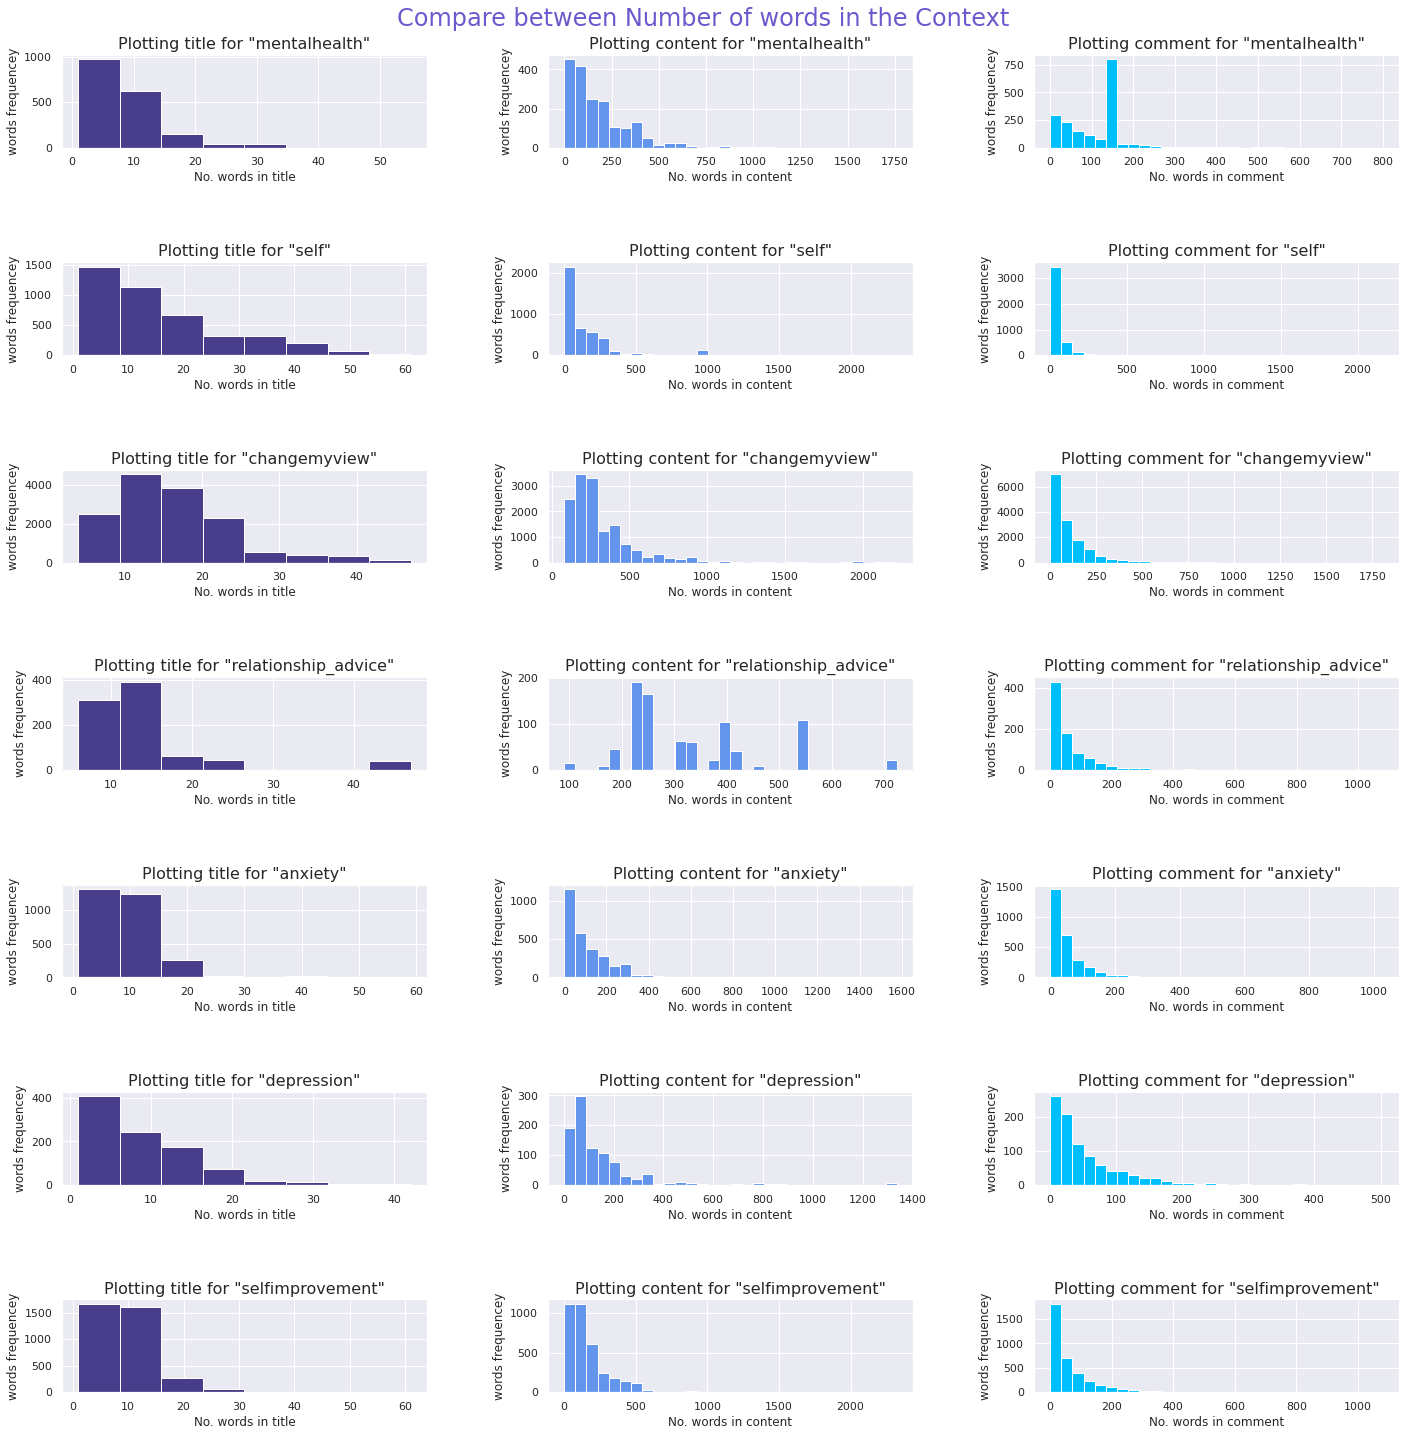

In [ ]:
from matplotlib.pyplot import title
sns.set(style='darkgrid')
fig, axes = plt.subplots(7, 3, figsize=(21, 21))
fig.suptitle('Compare between Number of words in the Context',
             size=24, color='SlateBlue')

colors = ['DarkSlateBlue', 'CornflowerBlue', 'DeepSkyBlue']

for x, topic in enumerate(LIST_OF_TOPICS):
  for y, (feature, bin, color) in enumerate(zip(LIST_OF_FEATURES[1:], BINS,
                                                colors)):
    plot_n_words(posts_copy,
                 column_name=feature,
                 subreddit_name=topic,
                 n_bins=bin,
                 color=color,
                 axes=axes[x, y])
fig.tight_layout(pad=5.0)
plt.show()

## Feature Engineering

### (A) Remove Markdown links

In [ ]:
def md_links(text: Text) -> Text:
  markdown_link=re.compile(r'\[.*?\]\(.*?\)')
  return markdown_link.sub(r'',text)

In [ ]:
posts_df['corrected_title'] = posts_df['title'].parallel_apply(lambda sentence: md_links(sentence))
posts_df['corrected_content'] = posts_df['content'].parallel_apply(lambda sentence: md_links(sentence))
posts_df['corrected_comment'] = posts_df['comment'].parallel_apply(lambda sentence: md_links(sentence))

### (B) Remove Links

In [ ]:
def scrape_links(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [ ]:
posts_df['corrected_title'] = posts_df['corrected_title'].parallel_apply(lambda sentence: scrape_links(sentence))
posts_df['corrected_content'] = posts_df['corrected_content'].parallel_apply(lambda sentence: scrape_links(sentence))
posts_df['corrected_comment'] = posts_df['corrected_comment'].parallel_apply(lambda sentence: scrape_links(sentence))

### (C) Dealing with Tags

In [ ]:
def remove_html(text: Text) -> Text:
  html=re.compile(r'<.*?>')
  return html.sub(r'',text)

In [ ]:
posts_df['corrected_title'] = posts_df['corrected_title'].parallel_apply(lambda sentence: remove_html(sentence))
posts_df['corrected_content'] = posts_df['corrected_content'].parallel_apply(lambda sentence: remove_html(sentence))
posts_df['corrected_comment'] = posts_df['corrected_comment'].parallel_apply(lambda sentence: remove_html(sentence))

### (D) Remove Numbers

In [ ]:
posts_df['corrected_title'] = posts_df['corrected_title'].str.replace(r'\d+', ' ', regex=True)
posts_df['corrected_content'] = posts_df['corrected_content'].str.replace(r'\d+', ' ', regex=True)
posts_df['corrected_comment'] = posts_df['corrected_comment'].str.replace(r'\d+', ' ', regex=True)

In [ ]:
posts_df['comment'][0]

"Thank you for for sharing. A reminder: if you are seeking resources in your local area, please provide that in the post so that users can share appropriate links and phone numbers. *If you are in distress, please call 9-1-1* or your local emergency number. *You are not alone. Help is available.* If you are having suicidal thoughts, please [click here for a list of crisis support services.](http://www.suicide.org/international-suicide-hotlines.html), If you are seeking therapy online, please [click here for a list of counselling services.](https://thelifelinecanada.ca/pattern-interrupt/ecounselling/) *If you feel well enough to do so, please do your part to enrich this community.* Now that you have posted, please leave a constructive, helpful comment on someone else's post. Filter by new to find posts with zero comments. Together, we make this community great. Thank you for being here. \n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of thi

In [ ]:
posts_df['corrected_comment'][0]

"Thank you for for sharing. A reminder: if you are seeking resources in your local area, please provide that in the post so that users can share appropriate links and phone numbers. *If you are in distress, please call  - - * or your local emergency number. *You are not alone. Help is available.* If you are having suicidal thoughts, please , If you are seeking therapy online, please  *If you feel well enough to do so, please do your part to enrich this community.* Now that you have posted, please leave a constructive, helpful comment on someone else's post. Filter by new to find posts with zero comments. Together, we make this community great. Thank you for being here. \n\n\n*I am a bot, and this action was performed automatically. Please  if you have any questions or concerns.*"

### (E) Char Words Converstion

#### Abbreviated Keywords

In [ ]:
CHAT_WORDS_STR = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
"""

#### Functions

In [ ]:
# First, we're going to convert this long string into set of words and its shortcut
chat_words_map_dict = {}
chat_shortcut_list = set()
for line in CHAT_WORDS_STR.split("\n"):
    if line != '':
        shortcut = line.split('=')[0] # split the line from `=` sign and select shortcut
        chat_words = line.split('=')[1]
        chat_shortcut_list.add(shortcut) # add the chat  shortcut to the set
        chat_words_map_dict[shortcut] = chat_words # add each chat_words corresponding to its shortcut

In [ ]:
def chat_words_conversion(text: Text) -> Text:
    new_text = []
    for word in text.split():
        if word.upper() in chat_words_map_dict:
            new_text.append(chat_words_map_dict[word.upper()])
        else:
            new_text.append(word)
    return " ".join(new_text)

In [ ]:
posts_df['corrected_title'] = posts_df['corrected_title'].parallel_apply(lambda sentence: chat_words_conversion(sentence))
posts_df['corrected_content'] = posts_df['corrected_content'].parallel_apply(lambda sentence: chat_words_conversion(sentence))
posts_df['corrected_comment'] = posts_df['corrected_comment'].parallel_apply(lambda sentence: chat_words_conversion(sentence))

### (G) Decode Emojis

In [ ]:
def is_emoji(text: Text)-> bool:
    for label in text:
        if label in emoji.UNICODE_EMOJI_ENGLISH:
            return True
    return False

In [ ]:
is_emoji_title = posts_df['corrected_title'].parallel_apply(lambda sentence: is_emoji(sentence))
is_emoji_content = posts_df['corrected_content'].parallel_apply(lambda sentence: is_emoji(sentence))
is_emoji_comment = posts_df['corrected_comment'].parallel_apply(lambda sentence: is_emoji(sentence))

In [ ]:
def decode_emoji(text: Text) -> Text:
  txt_emoji_list = emoji.distinct_emoji_lis(text)
  rx = '[' + re.escape(''.join(txt_emoji_list)) + ']'

  if not txt_emoji_list:
      return text
  elif '©' not in txt_emoji_list:
      return re.sub(rx, '', text) +\
      ''.join([emoji.demojize(emoj).replace(':', ' ') for emoj in txt_emoji_list])
  elif ('©' in txt_emoji_list and len(txt_emoji_list) == 1):
      return text.replace('©', '')
  elif ('©' in txt_emoji_list and len(txt_emoji_list) > 1):
      text = text.replace('©', '')
      return re.sub(rx, '', text) +\
      ''.join([emoji.demojize(emoj).replace(':', ' ') for emoj in txt_emoji_list])

In [ ]:
posts_df.loc[is_emoji_title, 'corrected_title'] = posts_df.loc[is_emoji_title, 'corrected_title'].parallel_apply(lambda sentence: decode_emoji(sentence))
posts_df.loc[is_emoji_content, 'corrected_content'] = posts_df.loc[is_emoji_content, 'corrected_content'].parallel_apply(lambda sentence: decode_emoji(sentence))
posts_df.loc[is_emoji_comment, 'corrected_comment'] = posts_df.loc[is_emoji_comment, 'corrected_comment'].parallel_apply(lambda sentence: decode_emoji(sentence))


### (H) Decode Emoticons

#### Dictionary of Emoticons

In [ ]:
# Thanks : https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py
EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

#### Functions

In [ ]:
def is_emot(text: Text)-> bool:
    for emo in EMOTICONS:
        if re.search(emo, text):
                return True
    return False

In [ ]:
is_emot_title = posts_df['corrected_title'].parallel_apply(lambda sentence: is_emot(sentence))
is_emot_content = posts_df['corrected_content'].parallel_apply(lambda sentence: is_emot(sentence))
is_emot_comment = posts_df['corrected_comment'].parallel_apply(lambda sentence: is_emot(sentence))

In [ ]:
def convert_emoticons_distinct(text: Text) -> Text:
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    
    # follow ref: https://stackoverflow.com/a/57231478/14473118
    text = re.sub(r'\b(\w+\s*)\1{1,}', '\\1', text)
    return text

In [ ]:
posts_df.loc[is_emot_title, 'corrected_title'] = posts_df.loc[is_emot_title, 'corrected_title'].parallel_apply(lambda sentence: convert_emoticons_distinct(sentence))
posts_df.loc[is_emot_content, 'corrected_content'] = posts_df.loc[is_emot_content, 'corrected_content'].parallel_apply(lambda sentence: convert_emoticons_distinct(sentence))
posts_df.loc[is_emot_comment, 'corrected_comment'] = posts_df.loc[is_emot_comment, 'corrected_comment'].parallel_apply(lambda sentence: convert_emoticons_distinct(sentence))

### (G) English contractions

In [ ]:
def en_contractions(text: Text) -> Text:
    return ' '.join([contractions.fix(word)
                     if word in contractions.contractions_dict else word
                     for word in text.split()])

In [ ]:
posts_df['corrected_title'] = posts_df['corrected_title'].parallel_apply(lambda sentence: en_contractions(sentence))
posts_df['corrected_content'] = posts_df['corrected_content'].parallel_apply(lambda sentence: en_contractions(sentence))
posts_df['corrected_comment'] = posts_df['corrected_comment'].parallel_apply(lambda sentence: en_contractions(sentence))

### (I) Dealing with Special Characters

In [ ]:
s_chars = '¥₽ÏïŰŬĎŸæ₿₪ÚŇÀèÅ”ĜåŽÖéříÿý€ŝĤ₹áŜŮÂ₴ûÌÇšŘúüëÓ₫ŠčÎŤÆÒœ₩öËäøÍťìĈôàĥÝ¢ç“žðÙÊĉŭÈŒÐÉÔĵùÁů„âÄűĴóêĝÞîØòď฿ČÜþňÛ'
PUNC = '+@«#_\-!$%%^&*¬()£<>?/\\|}\]\[{;\,~:\"\''

In [ ]:
def special_char(text: Text) -> Text:
    # first, let's remove any unicode strings
    text = text.encode('ascii', 'ignore').decode()
    # remove printable bachslashes
    text = re.sub(r'[\t\s\n\r\b\a]', ' ', text)
    # Special letters
    text = re.sub(r'[{}]'.format(s_chars), '', text)
    # Punctuation
    text = re.sub(r'[{}]'.format(PUNC), ' ', text)
    # space at the start or the end of the context
    text = re.sub(r'(^\s)|(\s$)', '', text)
    # Single character
    text = re.sub(r'(\s[^iIaA]\s)', ' ', text)
    return text

In [ ]:
posts_df['corrected_title'] = posts_df['corrected_title'].parallel_apply(lambda sentence: special_char(sentence))
posts_df['corrected_content'] = posts_df['corrected_content'].parallel_apply(lambda sentence: special_char(sentence))
posts_df['corrected_comment'] = posts_df['corrected_comment'].parallel_apply(lambda sentence: special_char(sentence))

### (J) Special Cases

In [ ]:
posts_df['corrected_title'] = posts_df['corrected_title'].str.replace("yr", 'year', regex=False)
posts_df['corrected_title'] = posts_df['corrected_title'].str.replace("...", ' ', regex=False)
posts_df['corrected_title'] = posts_df['corrected_title'].str.replace(r"\.|==|=|'|`|(PM)|(AM)|(UTC)", ' ', regex=True)
posts_df['corrected_title'] = posts_df['corrected_title'].str.replace(r"(\s[^iIaA]\s)", ' ', regex=True)
posts_df['corrected_title'] = posts_df['corrected_title'].str.replace(r'\s(\w$)|\s(\w[^me]$)', '', regex=True)
posts_df['corrected_title'] = posts_df['corrected_title'].str.replace(r'\s ', ' ', regex=True)
posts_df['corrected_title'] = posts_df['corrected_title'].str.replace(r'(^\s)|(\s$)', '', regex=True)

posts_df['corrected_content'] = posts_df['corrected_content'].str.replace("yr", 'year', regex=False)
posts_df['corrected_content'] = posts_df['corrected_content'].str.replace("...", ' ', regex=False)
posts_df['corrected_content'] = posts_df['corrected_content'].str.replace(r"\.|==|=|'|`|(PM)|(AM)|(UTC)", ' ', regex=True)
posts_df['corrected_content'] = posts_df['corrected_content'].str.replace(r"(\s[^iIaA]\s)", ' ', regex=True)
posts_df['corrected_content'] = posts_df['corrected_content'].str.replace(r'\s(\w$)|\s(\w[^me]$)', '', regex=True)
posts_df['corrected_content'] = posts_df['corrected_content'].str.replace(r'\s ', ' ', regex=True)
posts_df['corrected_content'] = posts_df['corrected_content'].str.replace(r'(^\s)|(\s$)', '', regex=True)

posts_df['corrected_comment'] = posts_df['corrected_comment'].str.replace("yr", 'year', regex=False)
posts_df['corrected_comment'] = posts_df['corrected_comment'].str.replace("...", ' ', regex=False)
posts_df['corrected_comment'] = posts_df['corrected_comment'].str.replace(r"\.|==|=|'|`|(PM)|(AM)|(UTC)", ' ', regex=True)
posts_df['corrected_comment'] = posts_df['corrected_comment'].str.replace(r"(\s[^iIaA]\s)", ' ', regex=True)
posts_df['corrected_comment'] = posts_df['corrected_comment'].str.replace(r'\s(\w$)|\s(\w[^me]$)', '', regex=True)
posts_df['corrected_comment'] = posts_df['corrected_comment'].str.replace(r'\s ', ' ', regex=True)
posts_df['corrected_comment'] = posts_df['corrected_comment'].str.replace(r'(^\s)|(\s$)', '', regex=True)

In [ ]:
posts_df['comment'][0]

"Thank you for for sharing. A reminder: if you are seeking resources in your local area, please provide that in the post so that users can share appropriate links and phone numbers. *If you are in distress, please call 9-1-1* or your local emergency number. *You are not alone. Help is available.* If you are having suicidal thoughts, please [click here for a list of crisis support services.](http://www.suicide.org/international-suicide-hotlines.html), If you are seeking therapy online, please [click here for a list of counselling services.](https://thelifelinecanada.ca/pattern-interrupt/ecounselling/) *If you feel well enough to do so, please do your part to enrich this community.* Now that you have posted, please leave a constructive, helpful comment on someone else's post. Filter by new to find posts with zero comments. Together, we make this community great. Thank you for being here. \n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of thi

In [ ]:
posts_df['corrected_comment'][0]

'Thank you for for sharing A reminder if you are seeking resources in your local area please provide that in the post so that users can share appropriate links and phone numbers If you are in distress please call or your local emergency number You are not alone Help is available If you are having suicidal thoughts please If you are seeking therapy online please If you feel well enough to do so please do your part to enrich this community Now that you have posted please leave a constructive helpful comment on someone else post Filter by new to find posts with zero comments Together we make this community great Thank you for being here I am a bot and this action was performed automatically Please if you have any questions or concerns'

In [ ]:
posts_df['title'][3]

'Is there something wrong with me?'

In [ ]:
posts_df['corrected_title'][3]

'Is there something wrong with me'

### (K) English contractions (Again)

In [ ]:
def en_contractions(text: Text) -> Text:
    return ' '.join([contractions.fix(word)
                     if word in contractions.contractions_dict else word
                     for word in text.split()])

In [ ]:
posts_df['corrected_title'] = posts_df['corrected_title'].parallel_apply(lambda sentence: en_contractions(sentence))
posts_df['corrected_content'] = posts_df['corrected_content'].parallel_apply(lambda sentence: en_contractions(sentence))
posts_df['corrected_comment'] = posts_df['corrected_comment'].parallel_apply(lambda sentence: en_contractions(sentence))

### (L) Spell Correction

In [ ]:
spelling = SpellChecker(distance=1)
def misspelt_words_fn(dataframe: pd.DataFrame, column: Text) -> Set[Text]:
    misspelt_words = set()
    for tweet in dataframe[column].str.casefold():
        [misspelt_words.add(word) for word in spelling.unknown(tweet.split())]
    return misspelt_words

***Misspelt words Before Analysis & Feature Engineering***

In [ ]:
# misspelt_title_bfr = misspelt_words_fn(posts_df, 'title')
# misspelt_content_bfr = misspelt_words_fn(posts_df, 'content')
# misspelt_comment_bfr = misspelt_words_fn(posts_df, 'comment')

# print(f'Title misspelt: {len(misspelt_title_bfr)}\ncontent misspelt: {len(misspelt_content_bfr)}\ncomment misspelt: {len(misspelt_comment_bfr)}')

***Misspelt words After Analysis & Feature Engineering***

In [ ]:
# misspelt_title_aft = misspelt_words_fn(posts_df, 'corrected_title')
# misspelt_content_aft = misspelt_words_fn(posts_df, 'corrected_content')
# misspelt_comment_aft = misspelt_words_fn(posts_df, 'corrected_comment')

# print(f'Title misspelt: {len(misspelt_title_aft)}\ncontent misspelt: {len(misspelt_content_aft)}\ncomment misspelt: {len(misspelt_comment_aft)}')

In [ ]:
WORD = re.compile(r'\w+')
def reTokenize(tweet: Text) -> List[Text]:
    return WORD.findall(tweet.casefold())

In [ ]:
PATTERN = re.compile(r"(.)\1{2,}", flags=re.IGNORECASE)
def reduce_lengthening(text: Text) -> Text:
    return PATTERN.sub(r"\1\1", text)

In [ ]:
def spell_correction(text: Text, misspelt_list: List[Text]) -> Text:
    return ' '.join([spelling.correction(word)
                     if word in misspelt_list else word
                     for word in reTokenize(reduce_lengthening(text))])

In [ ]:
misspelt_title = misspelt_words_fn(posts_df, 'corrected_title')
misspelt_content = misspelt_words_fn(posts_df, 'corrected_content')
misspelt_comment = misspelt_words_fn(posts_df, 'corrected_comment')

In [ ]:
posts_df['corrected_title'] = posts_df['corrected_title'].parallel_apply(lambda sentence: spell_correction(sentence, misspelt_title))
posts_df['corrected_content'] = posts_df['corrected_content'].parallel_apply(lambda sentence: spell_correction(sentence, misspelt_content))
posts_df['corrected_comment'] = posts_df['corrected_comment'].parallel_apply(lambda sentence: spell_correction(sentence, misspelt_comment))

***Reduce Duplicates***

In [ ]:
def rv_duplicates(text: Text) -> Text:
  return re.sub(r'\b(\w+\s*)\1{1,}', '\\1', text)

In [ ]:
posts_df['corrected_title'] = posts_df['corrected_title'].parallel_apply(lambda sentence: rv_duplicates(sentence))
posts_df['corrected_content'] = posts_df['corrected_content'].parallel_apply(lambda sentence: rv_duplicates(sentence))
posts_df['corrected_comment'] = posts_df['corrected_comment'].parallel_apply(lambda sentence: rv_duplicates(sentence))

***Misspelt words After Correction***

In [ ]:
# misspelt_title_aft_corr = misspelt_words_fn(posts_df, 'corrected_title')
# misspelt_content_aft_corr = misspelt_words_fn(posts_df, 'corrected_content')
# misspelt_comment_aft_corr = misspelt_words_fn(posts_df, 'corrected_comment')

# print(f'Title misspelt: {len(misspelt_title_aft_corr)}\ncontent misspelt: {len(misspelt_content_aft_corr)}\ncomment misspelt: {len(misspelt_comment_aft_corr)}')

Title misspelt: 240
content misspelt: 2481
comment misspelt: 6324


### (M) Removing unnecessary rows depends on score

In [ ]:
def drop_empty(dataframe: pd.DataFrame) -> pd.DataFrame:
  dataframe = dataframe[(dataframe['thread_score'] >= 1) |\
                        (dataframe['comment_score'] >= 1)]
  dataframe = dataframe.loc[(dataframe['title'] != ' ')  |\
                            (dataframe['title'] != '')   |\
                            (dataframe['comment'] != ' ')|\
                            (dataframe['comment'] != '') |                    
                            (dataframe['content'] != ' ')|\
                            (dataframe['content'] != '')]
  dataframe.reset_index(drop=True, inplace=True, )
  return dataframe

In [ ]:
posts_df = drop_empty(posts_df)

In [ ]:
posts_df

,id,subreddit,title,content,thread_score,comment,comment_score,corrected_title,corrected_content,corrected_comment
0,swijxe,mentalhealth,Once again...Schizophrenia Episodes Caught On Camera,"I'm Michelle Hammer and I have Schizophrenia. I set up a security camera to record myself having schizophrenia psychosis episodes. In this video, I show 3 different episodes I had while sitting on...",1,"Thank you for for sharing. A reminder: if you are seeking resources in your local area, please provide that in the post so that users can share appropriate links and phone numbers. *If you are in ...",1,once again schizophrenia episodes caught on camera,i am michelle hammer and i have schizophrenia i set up a security camera to record myself having schizophrenia psychosis episodes in this video i show different episodes i had while sitting on my ...,thank you for sharing a reminder if you are seeking resources in your local area please provide that in the post so that users can share appropriate links and phone numbers if you are in distress ...
1,swifud,mentalhealth,why does everything stress me out,literally nothing like deciding to hang out with my friend later will repeat in my head until i go insane. maybe even like getting one question wrong on a test will stay with me for hours on end. ...,1,"Thank you for for sharing. A reminder: if you are seeking resources in your local area, please provide that in the post so that users can share appropriate links and phone numbers. *If you are in ...",1,why does everything stress me out,literally nothing like deciding to hang out with my friend later will repeat in my head until i go insane maybe even like getting one question wrong on a test will stay with me for hours on end in...,thank you for sharing a reminder if you are seeking resources in your local area please provide that in the post so that users can share appropriate links and phone numbers if you are in distress ...
2,swiepa,mentalhealth,I’ve got appointment with the early invention team this coming Monday,I’m wondering if I should write stuff down as been trying to get help for years now and don’t what to forget anything the other half of me is worried that if I do that they will think I’m exaggera...,1,"Thank you for for sharing. A reminder: if you are seeking resources in your local area, please provide that in the post so that users can share appropriate links and phone numbers. *If you are in ...",1,i have got appointment with the early invention team this coming monday,i am wondering if i should write stuff down as been trying to get help for years now and do not what to forget anything the other half of me is worried that if i do that they will think i am exagg...,thank you for sharing a reminder if you are seeking resources in your local area please provide that in the post so that users can share appropriate links and phone numbers if you are in distress ...
3,swicrr,mentalhealth,Is there something wrong with me?,I'm a junior in high school and I haven't made one new friend in my entire time here. No one's ever approached me and tried to talk to me unless they were just asking a work related question. I've...,2,"Thank you for for sharing. A reminder: if you are seeking resources in your local area, please provide that in the post so that users can share appropriate links and phone numbers. *If you are in ...",1,is there something wrong with me,i am a junior in high school and i have not made one new friend in my entire time here no one ever approached me and tried to talk to me unless they were just asking a work related question i have...,thank you for sharing a reminder if you are seeking resources in your local area please provide that in the post so that users can share appropriate links and phone numbers if you are in distress ...
4,swicrr,mentalhealth,Is there something wrong with me?,I'm a junior in high school and I haven't made one new friend in my entire time here. No one's ever approached me and tried to talk to

### (L) Restore Punctuations

***Remove the unnecessary columns***

In [ ]:
posts_df.drop(columns=['title', 'content', 'comment'], inplace=True)

#### Theano

In [ ]:
# punc = Punctuator('Punctuator/INTERSPEECH-T-BRNN.pcl')

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [ ]:
# def restore_punc(text: Text) -> Text:
#   if text != ' ':
#     return punc.punctuate(text)
#   return text

In [ ]:
# posts_df['corrected_title'][1944]

'i am probably blocked by more people than most'

In [ ]:
# punc.punctuate(posts_df['corrected_title'][1944])

'I am probably blocked by more people than most.'

#### Tokens

In [ ]:
class AutoPunctuator:

  @classmethod
  def __config(cls):
    args = InferenceArguments(
                  model_name_or_path="Qishuai/distilbert_punctuator_en",
                  tokenizer_name="Qishuai/distilbert_punctuator_en",
                  tag2punctuator=DEFAULT_ENGLISH_TAG_PUNCTUATOR_MAP,
    )
    inference = Inference(inference_args=args, verbose=False)
    return inference
  
  @staticmethod
  def _batching_series(series: pd.DataFrame, batch_size: int) -> List[List[Text]]:
    series = series.tolist()
    return [series[i:i + batch_size] 
            for i in range(0, len(series), batch_size)]
  
  def __init__(self,
               dataframe: pd.DataFrame,
               series_batch_size: int) -> None:

    self.inference = AutoPunctuator.__config()
    self.dataframe = dataframe
    self.batch_size = series_batch_size
    self.container = []

  def punctuation(self, column_name: Text, text_len: int) -> pd.DataFrame:
    batches = AutoPunctuator._batching_series(self.dataframe[column_name],
                                              self.batch_size)
    print(' Auto Recover Punctuator '.center(100, '='))
    for batch in tqdm(batches, desc=f'Punctuation recovery for [{column_name}]'):
      try:
        self.container.append(
            self.inference.punctuation(batch)[0]
        )
      except TypeError:
        print('Issue with the server conversion or you have an issue with the dataset: Length of the sentence or an empty string.')
        print('Wating for response... [10 secs]')
        time.sleep(10)
        print('Re-insert the batch...')
        try:
          self.container.append(
              self.inference.punctuation(batch)[0]
          )
          print('Sucessfully inserted the batch!')
        except TypeError:
          print('Issue with the dataset')
          print('Insert None for the recent batch...')
          self.container.append([None])
          print('Sucessfully inserted the None!')

      if text_len >= 200:
        time.sleep(0.5)
      else:
        time.sleep(0.1)

    print(' Building the New Dataframe '.center(50, '+'))
    # concatenate all the mini-batches
    flatten = [val for sublist in self.container for val in sublist]
    dataset = pd.DataFrame({column_name: flatten})
    print(' Done Punctuation Recovery! '.center(100, '='))

    self.container.clear()
    
    return dataset

In [ ]:
punc = AutoPunctuator(posts_df, 1)

2022-03-05 10:37:42,725 - INFO - inference_interface.py:75 - inference_interface._produce_server - 4374 - set up punctuator
2022-03-05 10:37:48,518 - INFO - inference_interface.py:88 - inference_interface._produce_server - 4374 - start running punctuator
2022-03-05 10:37:49,982 - INFO - inference_interface.py:91 - inference_interface._produce_server - 4374 - start client


In [ ]:
posts_df['punc_corrected_title'] = punc.punctuation('corrected_title', 100)

===================================== Auto Recover Punctuator ======================================


Punctuation recovery for [corrected_title]:   0%|          | 0/28628 [00:00<?, ?it/s]

+++++++++++ Building the New Dataframe +++++++++++
==================================== Done Punctuation Recovery! ====================================


In [ ]:
time.sleep(10)

In [ ]:
posts_df['punc_corrected_content'] = punc.punctuation('corrected_content', 150)

===================================== Auto Recover Punctuator ======================================


Punctuation recovery for [corrected_content]:   0%|          | 0/28628 [00:00<?, ?it/s]

+++++++++++ Building the New Dataframe +++++++++++
==================================== Done Punctuation Recovery! ====================================


In [ ]:
time.sleep(10)

In [ ]:
posts_df['punc_corrected_comment'] = punc.punctuation('corrected_comment', 150)

===================================== Auto Recover Punctuator ======================================


Punctuation recovery for [corrected_comment]:   0%|          | 0/28628 [00:00<?, ?it/s]

+++++++++++ Building the New Dataframe +++++++++++
==================================== Done Punctuation Recovery! ====================================


### Lemmatization

In [ ]:
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

In [ ]:
# lemmatizer = WordNetLemmatizer()
# wordnet_map = {'N': wordnet.NOUN, 'V': wordnet.VERB, 'J': wordnet.ADJ, 'R': wordnet.ADJ}
# def adjusted_lemmatizer(text: Text) -> Text:
#     # Split the snetence into words and each word with its type
#     pos_tagged_text = nltk.pos_tag(text.split())
#     return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN))
#                      for word, pos in pos_tagged_text])

In [ ]:
# posts_df['title_lemmatized'] = posts_df['corrected_title'].parallel_apply(lambda sentence: adjusted_lemmatizer(sentence))
# posts_df['content_lemmatized'] = posts_df['corrected_content'].parallel_apply(lambda sentence: adjusted_lemmatizer(sentence))
# posts_df['comment_lemmatized'] = posts_df['corrected_comment'].parallel_apply(lambda sentence: adjusted_lemmatizer(sentence))

In [ ]:
# posts_df['title_lemmatized'] = posts_df['title_lemmatized'].str.replace(r"(\s[\w^iIaA]\s)|(\s[\w\s\w^iIaA]\s)|(\s[^iIaA]$)",
#                                                   ' ', regex=True)
# posts_df['title_lemmatized'] = posts_df['title_lemmatized'].str.replace('  ', ' ')
# posts_df['title_lemmatized'] = posts_df['title_lemmatized'].str.replace('   ', ' ')

# posts_df['content_lemmatized'] = posts_df['content_lemmatized'].str.replace(r"(\s[\w^iIaA]\s)|(\s[\w\s\w^iIaA]\s)|(\s[^iIaA]$)",
#                                                   ' ', regex=True)
# posts_df['content_lemmatized'] = posts_df['content_lemmatized'].str.replace('  ', ' ')
# posts_df['content_lemmatized'] = posts_df['content_lemmatized'].str.replace('   ', ' ')

# posts_df['comment_lemmatized'] = posts_df['comment_lemmatized'].str.replace(r"(\s[\w^iIaA]\s)|(\s[\w\s\w^iIaA]\s)|(\s[^iIaA]$)",
#                                                   ' ', regex=True)
# posts_df['comment_lemmatized'] = posts_df['comment_lemmatized'].str.replace('  ', ' ')
# posts_df['comment_lemmatized'] = posts_df['comment_lemmatized'].str.replace('   ', ' ')

In [ ]:
# misspelt_lemmatize_title = misspelt_words_fn(posts_df, 'title_lemmatized')
# misspelt_lemmatize_content = misspelt_words_fn(posts_df, 'content_lemmatized')
# misspelt_lemmatize_comment = misspelt_words_fn(posts_df, 'comment_lemmatized')

# print(f'Title Lemmatize misspelt: {len(misspelt_title)}\ncontent Lemmatize misspelt: {len(misspelt_content)}\ncomment Lemmatize misspelt: {len(misspelt_comment)}')

### Dataset

***Rename columns***

In [ ]:
posts_df.drop(columns=['corrected_title', 'corrected_content',
                       'corrected_comment'], inplace=True)

posts_df.rename(columns={'punc_corrected_title':'title',
                         'punc_corrected_content': 'content',
                         'punc_corrected_comment': 'comment'},
                inplace=True)

In [ ]:
LIST_OF_TOPICS = ['mentalhealth', 'self', 'changemyview', 'relationship_advice', 'anxiety', 'depression', 'selfimprovement']
LIST_OF_FEATURES = ['subreddit', 'title', 'content', 'comment']
BINS = [8, 30, 30]

In [ ]:
posts_df.isna().value_counts().T

id     subreddit  thread_score  comment_score  title  content  comment
False  False      False         False          False  False    False      28628
dtype: int64

In [ ]:
posts_df.dropna(inplace=True)

In [ ]:
posts_df.isna().value_counts()

id     subreddit  thread_score  comment_score  title  content  comment
False  False      False         False          False  False    False      28628
dtype: int64

In [ ]:
posts_df.groupby('subreddit').count()

,id,thread_score,comment_score,title,content,comment
subreddit,,,,,,
anxiety,2855,2855,2855,2855,2855,2855
changemyview,14329,14329,14329,14329,14329,14329
depression,932,932,932,932,932,932
mentalhealth,1843,1843,1843,1843,1843,1843
relationship_advice,855,855,855,855,855,855
self,4193,4193,4193,4193,4193,4193
selfimprovement,3621,3621,3621,3621,3621,3621


In [ ]:
posts_df

,id,subreddit,thread_score,comment_score,title,content,comment
0,swijxe,mentalhealth,1,1,Once again schizophrenia episodes caught on camera.,"I am michelle hammer and i have schizophrenia i set up a security camera to record myself having schizophrenia, psychosis episodes. In this video i show different episodes i had while sitting on m...","Thank you for sharing a reminder if you are seeking resources in your local area, please provide that in the post so that users can share appropriate links and phone numbers if you are in distress..."
1,swifud,mentalhealth,1,1,Why does everything stress me out?,"Literally nothing like deciding to hang out with my friend later, will repeat in my head until i go insane maybe even like getting one question wrong on a test will stay with me for hours on end i...","Thank you for sharing a reminder if you are seeking resources in your local area, please provide that in the post so that users can share appropriate links and phone numbers if you are in distress..."
2,swiepa,mentalhealth,1,1,I have got appointment with the early invention team this coming monday.,"I am wondering if i should write stuff down as been trying to get help for years now and do not what to forget anything. The other half of me is worried that if i do that, they will think i am exa...","Thank you for sharing a reminder if you are seeking resources in your local area, please provide that in the post so that users can share appropriate links and phone numbers if you are in distress..."
3,swicrr,mentalhealth,2,1,Is there something wrong with me?,"I am a junior in high school, and i have not made one new friend in my entire time here. No one ever approached me and tried to talk to me unless they were just asking a work related question. I h...","Thank you for sharing a reminder if you are seeking resources in your local area, please provide that in the post so that users can share appropriate links and phone numbers if you are in distress..."
4,swicrr,mentalhealth,2,2,Is there something wrong with me?,"I am a junior in high school, and i have not made one new friend in my entire time here. No one ever approached me and tried to talk to me unless they were just asking a work related question. I h...","I do not think there is anything wrong with you. Highschool is brutal. That is the just of it. Highschool sucks. If you do not have any friends heading into highschool, you will have a difficult t..."
...,...,...,...,...,...,...,...
28623,sjvfj1,selfimprovement,197,1,I am scared of making mistakes to the point i avoid the possibily of making them,"This is my biggest problem in life. All my years, i have been programmed to the mindset that making mistakes are bad and that you have to be perfect. I now know deep inside that thats not true, bu...","Hello, my friend, it and foremost, you are valuing yourself and others too much based on brain capacity. Being smart is a nice thing, but it is not an essential thing. Essentials are being trustwo..."
28624,sjvfj1,selfimprovement,197,1,I am scared of making mistakes to the point i avoid the possibily of making them,"This is my biggest problem in life. All my years, i have been programmed to the mindset that making mistakes are bad and that you have to be perfect. I now know deep inside that thats not true, bu...",Its very difficult to feel stuck and not know how to proceed i follow the works of the holistic psychologist on ig for analysis on trauma reactions and inner child works. Hope it helps.
28625,sjvfj1,selfimprovement,197,1,I am scared of making mistakes to the point i avoid the possibily of making them,"This is my biggest problem in life. All my years, i have been programmed to the mindset that making mistakes are bad and that you have to be perfect. I now know deep inside that thats not true, bu...",Welcome to the club.
28626,sjvfj1,selfimprovement,197,1,I am scared of making mistakes to the point i avoid the possibily of making them,"This is my biggest problem in life. All my year

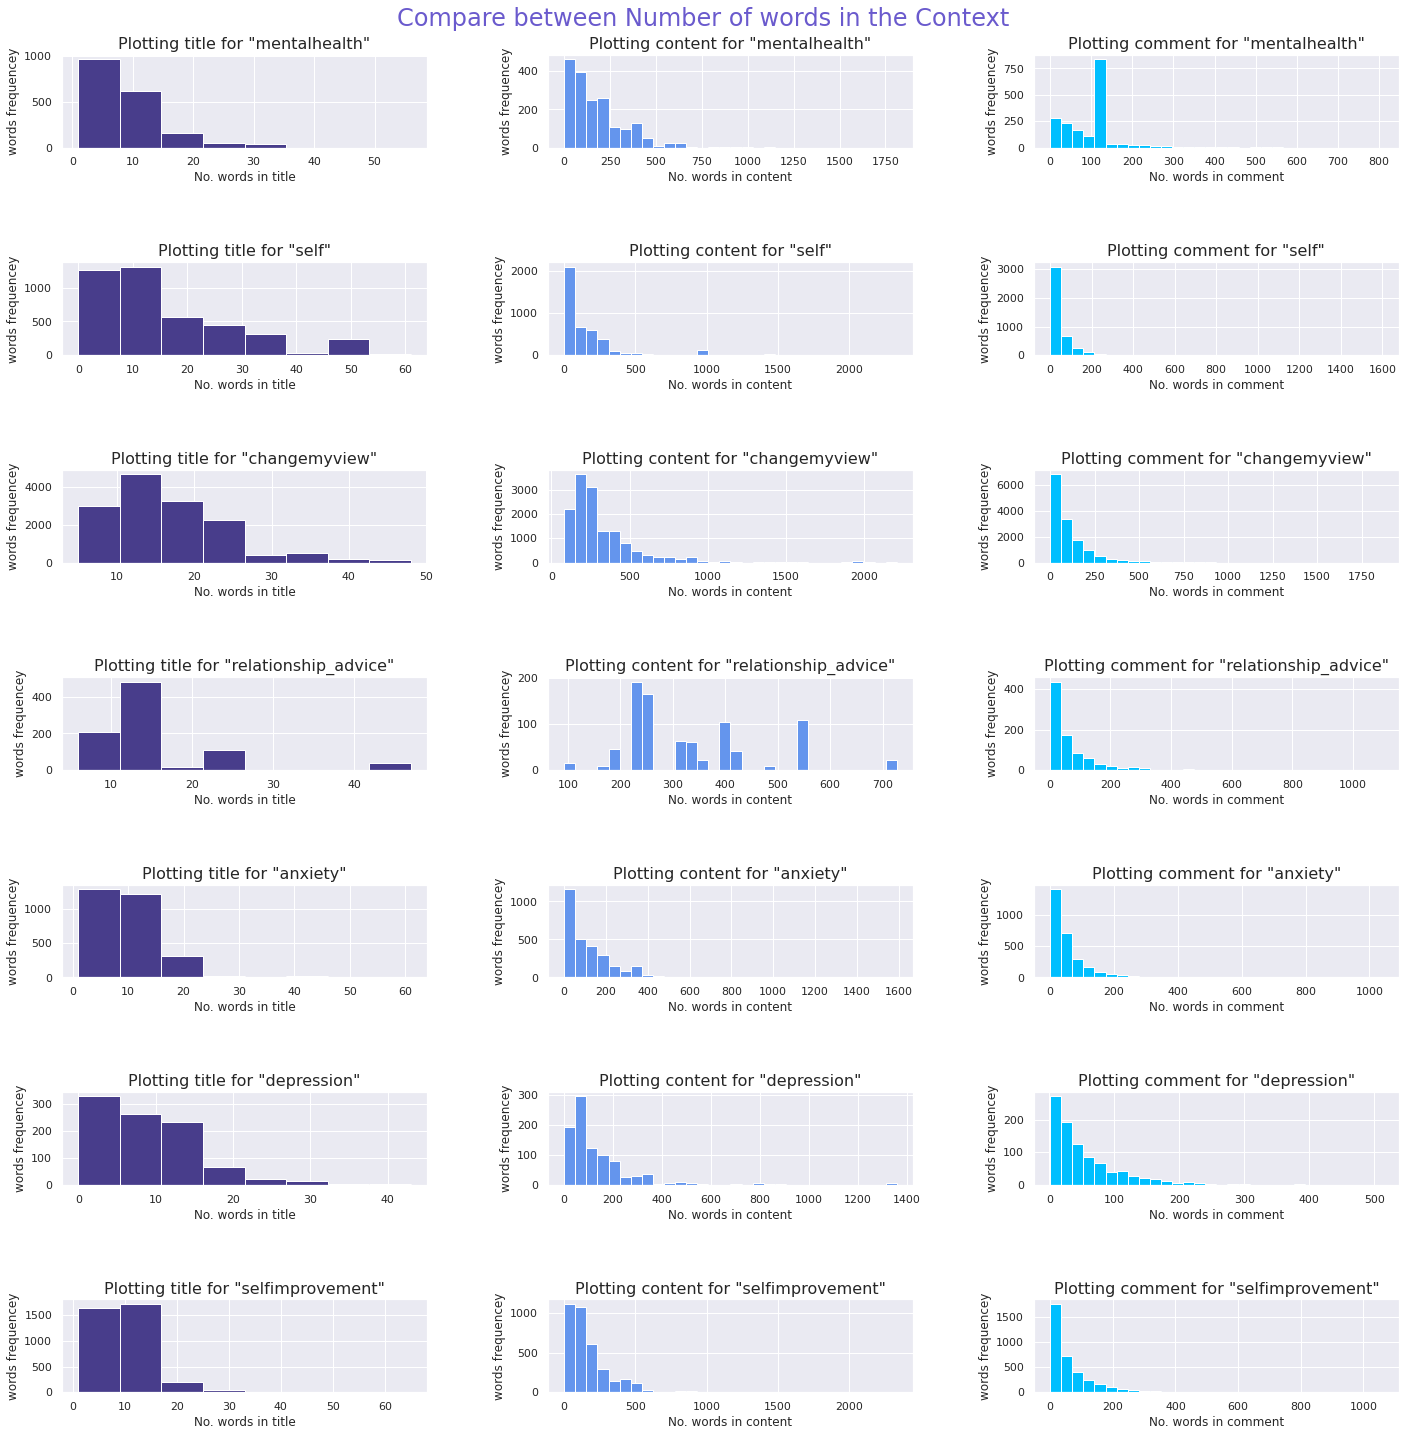

In [ ]:
from matplotlib.pyplot import title
sns.set(style='darkgrid')
fig, axes = plt.subplots(7, 3, figsize=(21, 21))
fig.suptitle('Compare between Number of words in the Context',
             size=24, color='SlateBlue')

colors = ['DarkSlateBlue', 'CornflowerBlue', 'DeepSkyBlue']

for x, topic in enumerate(LIST_OF_TOPICS):
  for y, (feature, bin, color) in enumerate(zip(LIST_OF_FEATURES[1:], BINS,
                                                colors)):
    plot_n_words(posts_df,
                 column_name=feature,
                 subreddit_name=topic,
                 n_bins=bin,
                 color=color,
                 axes=axes[x, y])
fig.tight_layout(pad=5.0)
plt.show()

### Data Readability

In [ ]:
import inspect
funcs = ["textstat." + inspect.getmembers(textstat, predicate=inspect.ismethod)[i][0] for i in range(1,28)]

In [ ]:
title = '\n'.join(set(posts_df['title'].tolist()))
content = '\n'.join(set(posts_df['content'].tolist()))
comment = '\n'.join(set(posts_df['comment'].tolist()))

In [ ]:
def readability(title: Text, text: Text) -> None:
  print(f' {title} '.center(100, '='))
  for elem in funcs:
    method = eval(elem)
    textstat.set_lang("en")
    print(elem.split(".")[1])
    print(method(text))
    print(" ")

***Write the Report on Text file***

In [ ]:
from contextlib import redirect_stdout
with open('readability_report_after_punc.txt', 'w') as f:
    with redirect_stdout(f):
      for title, text in zip(['title', 'content', 'comment'], [title, content, comment]):
        readability(title, text)

### Save the Dataset


In [ ]:
posts_df.to_feather('Dataset/cleaned_dataset.feather')